### Time to get you hands dirty! A noisy detector.

Three telescopes are monitoring the same astronomical event. Their time-series output is provided  at `solutions/noisydetector.npy`. These could be the outputs of three photometry CCD cameras we still need to calibrate, or the strain channel from a gravitational-wave detectors. 

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA, PCA
import scipy

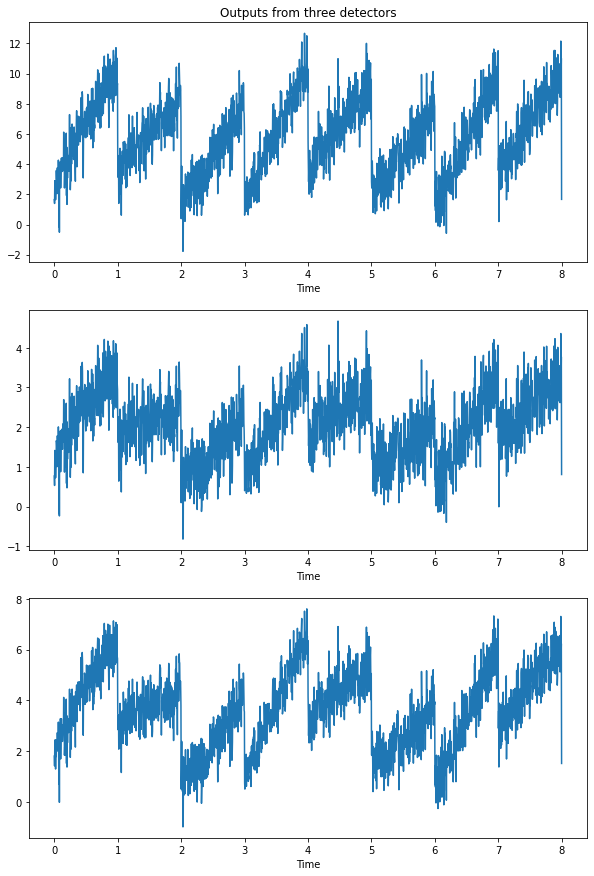

In [5]:
X=np.load('../solutions/noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');


In a realistic scenario, those jumps will have a physical meaning. Say for a satellite we need to [re-point the radio antennas](https://arxiv.org/abs/1907.04747) to send data down to Earth, and the whole thing shakes a bit. Or say the [the Starlink satellites](https://www.science.org/content/article/starlink-already-threatens-optical-astronomy-now-radio-astronomers-are-worried) are polluting your telescope data (I'm making this up, I don't really know what kind of data contamination they would cause!).


***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.

(When detecting a signal, state-of-the-art gravitational-wave analysis make use of another tecnique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) which, unfortunately, we do not have time to cover here. But PCA is used to classify instrumental artifacts, see e.g. [Powell et al 2005](https://arxiv.org/abs/1505.01299)).

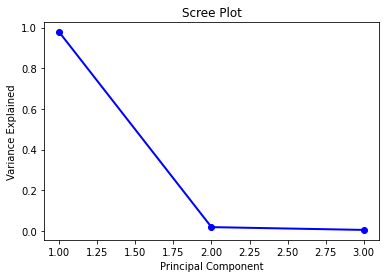

(2000, 3)


In [8]:
components = 3

#define PCA model to use
pca = PCA(n_components=components)

#fit PCA model to data
pca_fit = pca.fit_transform(X)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print(pca_fit.shape)

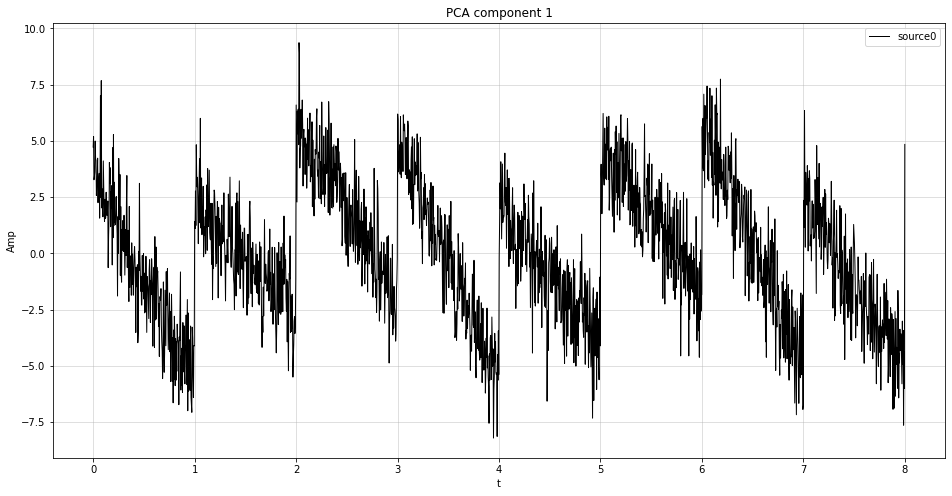

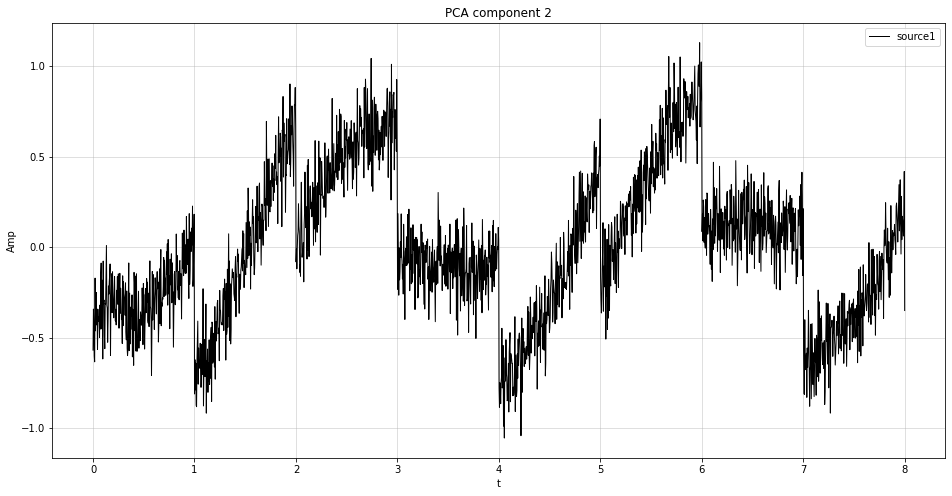

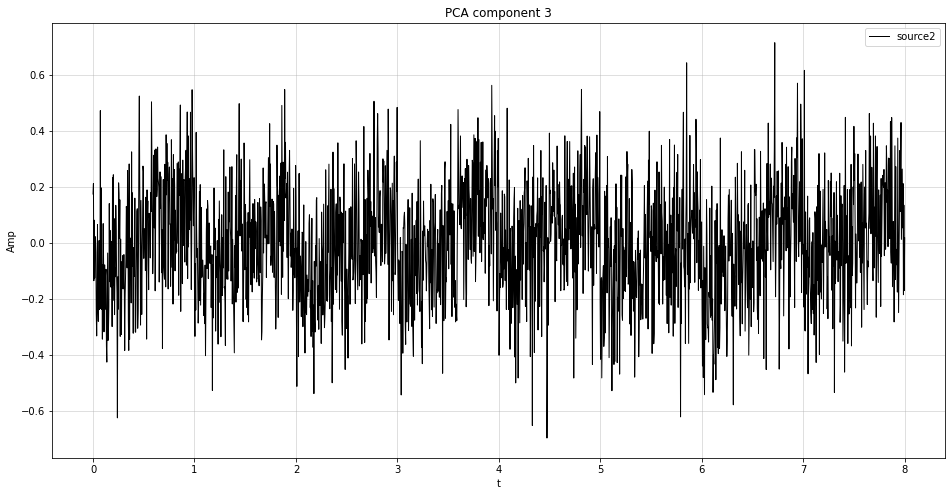

In [17]:
for i in range(components):
    plt.figure(figsize=(16, 8))
    plt.title("PCA component " + str(i+1))
    plt.plot(time, pca_fit[:,i], color = "black", label = 'source' + str(i), linewidth = 1)
    plt.grid(alpha = 0.5)
    plt.xlabel('t')
    plt.ylabel('Amp')
    plt.legend()
    plt.show()

PCA is not able to separate the signal into the original components, try with ICA

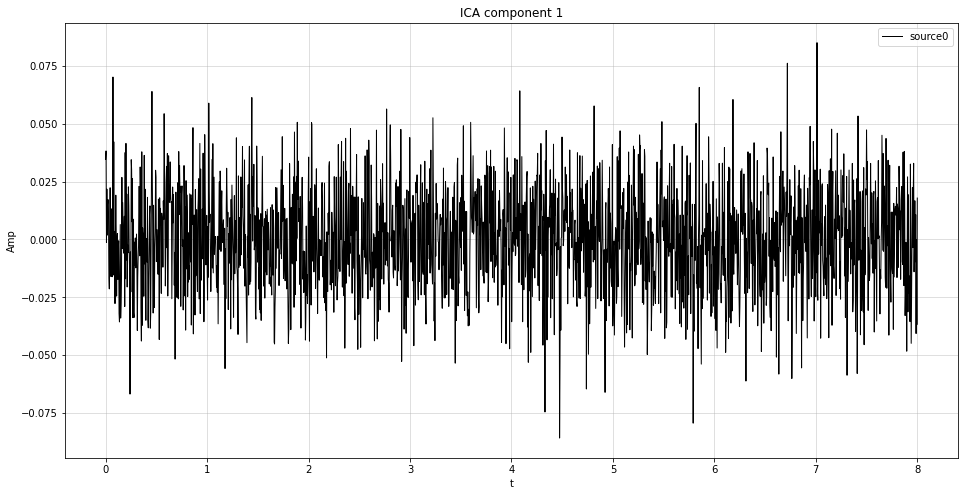

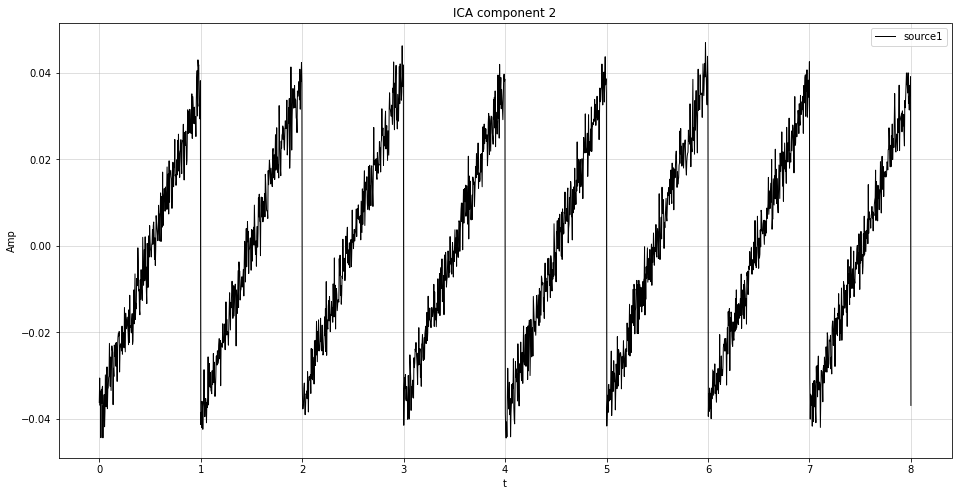

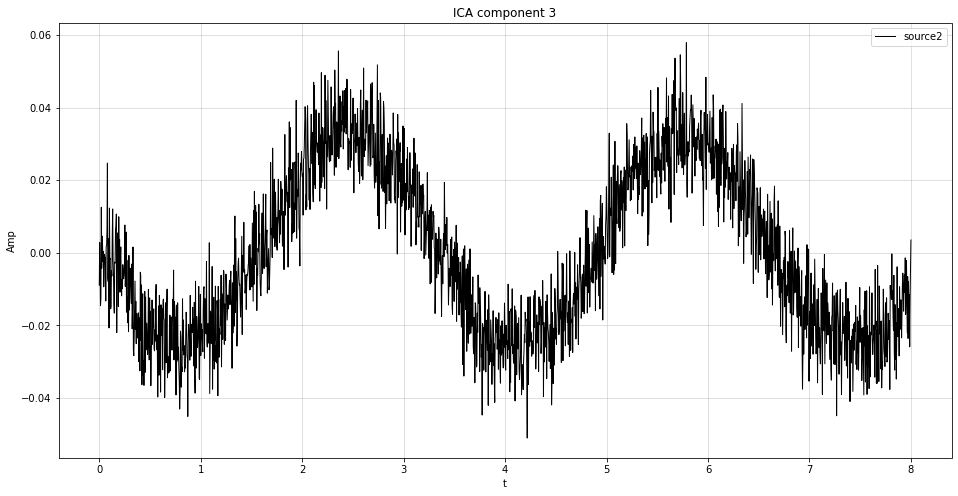

In [16]:
ica = FastICA(n_components=3)
ica_fit = ica.fit_transform(X)  # Reconstruct signals
ica_matrix = ica.mixing_  # Get estimated mixing matrix

for i in range(components):
    plt.figure(figsize=(16, 8))
    plt.title("ICA component " + str(i +1))
    plt.plot(time, ica_fit[:,i], color = "black", label = 'source' + str(i), linewidth = 1)
    plt.grid(alpha = 0.5)
    plt.xlabel('t')
    plt.ylabel('Amp')
    plt.legend()
    plt.show()

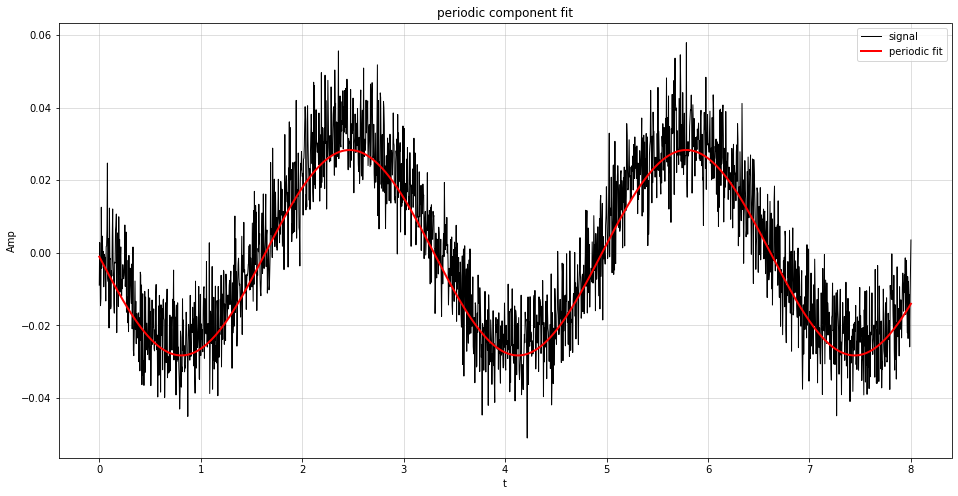

the period of Cepheid signal is T = 3.3180166360818095 +/- 0.008228796666451715


In [29]:
from scipy import optimize

def periodic_signal(x, A, T, phi):
    return A * np.sin(((2*np.pi)/np.abs(T)) * x + phi)

params, params_covariance = optimize.curve_fit(periodic_signal, time, ica_fit[:,2], p0=[0.04, 4, 0])

plt.figure(figsize=(16, 8))
plt.title("periodic component fit")
plt.plot(time, ica_fit[:,2], color = "black", label = "signal", linewidth = 1)
plt.plot(time, periodic_signal(time, params[0], params[1], params[2]), color = "red", label = "periodic fit", linewidth = 2)
plt.grid(alpha = 0.5)
plt.xlabel('t')
plt.ylabel('Amp')
plt.legend()
plt.show()

print("the period of Cepheid signal is T = " + str(params[1]) + " +/- " + str(np.sqrt(params_covariance[1,1])))

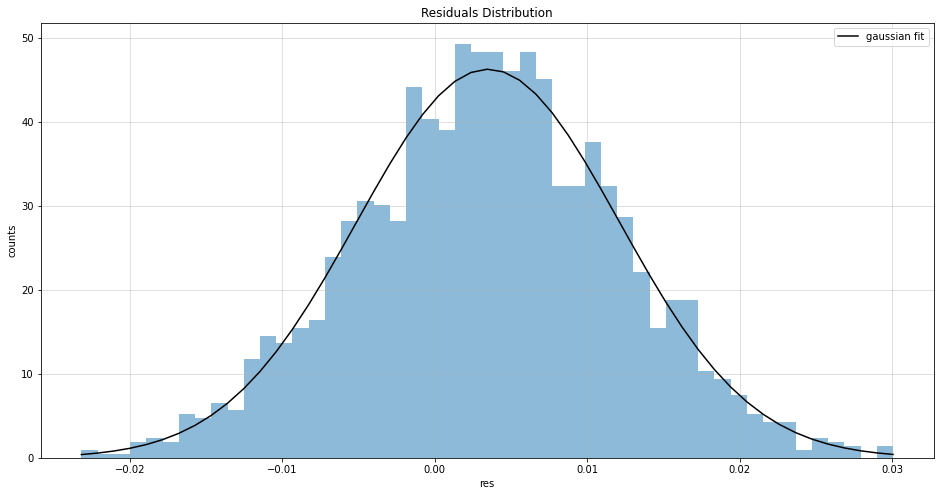

In [23]:
#study residual distribution: if gaussian can compute chi2
residuals = ica_fit[:,2] - periodic_signal(time, params[0], params[1], params[2])

plt.figure(figsize=(16, 8))
plt.title("Residuals Distribution")
_, bins, _ = plt.hist(residuals, bins = 50, density = True, alpha = 0.5)

mu, sigma = scipy.stats.norm.fit(residuals)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line, color = 'black', label = 'gaussian fit')


plt.grid(alpha = 0.5)
plt.xlabel('res')
plt.ylabel('counts')
plt.legend()
plt.show()

In [25]:
print('Chi Square = ', scipy.stats.normaltest(residuals))

Chi Square =  NormaltestResult(statistic=0.9589351011733304, pvalue=0.6191129503889405)
